In [7]:
from pyalgotrade import strategy
from pyalgotrade.technical import ma
from pyalgotrade.technical import cross


class SMACrossOver(strategy.BacktestingStrategy):
    def __init__(self, feed, instrument, smaPeriod):
        super(SMACrossOver, self).__init__(feed)
        self.__instrument = instrument
        self.__position = None
        # We'll use adjusted close values instead of regular close values.
        self.setUseAdjustedValues(True)
        self.__prices = feed[instrument].getPriceDataSeries()
        self.__sma = ma.SMA(self.__prices, smaPeriod)

    def getSMA(self):
        return self.__sma

    def onEnterCanceled(self, position):
        self.__position = None

    def onExitOk(self, position):
        self.__position = None

    def onExitCanceled(self, position):
        # If the exit was canceled, re-submit it.
        self.__position.exitMarket()

    def onBars(self, bars):
        # If a position was not opened, check if we should enter a long position.
        if self.__position is None:
            if cross.cross_above(self.__prices, self.__sma) > 0:
                shares = int(self.getBroker().getCash() * 0.9 / bars[self.__instrument].getPrice())
                # Enter a buy market order. The order is good till canceled.
                self.__position = self.enterLong(self.__instrument, shares, True)
        # Check if we have to exit the position.
        elif not self.__position.exitActive() and cross.cross_below(self.__prices, self.__sma) > 0:
            self.__position.exitMarket()

2021-01-04 16:06:53,889 strategy [INFO] Final portfolio value: $1295171.32


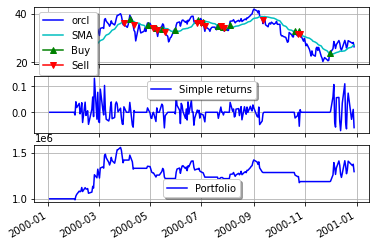

In [8]:
from pyalgotrade import plotter
from pyalgotrade.barfeed import quandlfeed
from pyalgotrade.stratanalyzer import returns

# Load the bar feed from the CSV file
feed = quandlfeed.Feed()
feed.addBarsFromCSV("orcl", "../WIKI-ORCL-2000-quandl.csv")

# Evaluate the strategy with the feed's bars.
myStrategy = SMACrossOver(feed, "orcl", 20)

# Attach a returns analyzers to the strategy.
returnsAnalyzer = returns.Returns()
myStrategy.attachAnalyzer(returnsAnalyzer)

# Attach the plotter to the strategy.
plt = plotter.StrategyPlotter(myStrategy)
# Include the SMA in the instrument's subplot to get it displayed along with the closing prices.
plt.getInstrumentSubplot("orcl").addDataSeries("SMA", myStrategy.getSMA())
# Plot the simple returns on each bar.
plt.getOrCreateSubplot("returns").addDataSeries("Simple returns", returnsAnalyzer.getReturns())

# Run the strategy.
myStrategy.run()
myStrategy.info("Final portfolio value: $%.2f" % myStrategy.getResult())

# Plot the strategy.
plt.plot()